In [1]:
%matplotlib inline
import numpy as np
import sys
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

## Task 1 Gibbs Sampling

In [2]:
def read_file(filename):
    with open("20newsgroups/" + filename, 'r') as f:
        data = f.read().split(" ")
        data.remove("")
    return data

In [3]:
# Initialization:

# Initialize constants
K = 20
D = 200
alpha = 50.0/K
beta = 0.1
N_iters = 500

# Initialize d(n) and z()
data = np.array([])
d = np.array([],dtype = int)
z = np.array([],dtype = int)
for i in range(1,D+1):
    data_i = read_file(str(i))
    l_i = len(data_i)
    d_i = i*np.ones([1,l_i], dtype = int)
    z_i = np.random.randint(1, K+1, [1,l_i])
    
    data = np.append(data, data_i)
    d = np.append(d, d_i)
    z = np.append(z, z_i)

N_words = len(data)

Vocab = list(set(data))
Vocab.sort()
V = len(Vocab)

# Initialize w(n), coverting a list of words
# into a list of indices of the words
word_index = dict.fromkeys(Vocab,0)
for i in range(len(Vocab)):
    word_index[Vocab[i]] = i+1
w = np.zeros(N_words, dtype = int)
for i in range(N_words):
    w[i] = word_index[data[i]]

# Initialized pi
pi = np.random.permutation(range(0,N_words))

# Compute Cd and Ct
Cd = np.zeros([D,K])
for i in range(D):
    for j in range(K):
        Cd[i,j] = sum((d == i+1) * (z == j+1))
        
Ct = np.zeros([K,V])
for i in range(K):
    for j in range(V):
        Ct[i,j] = sum((z == i+1) * (w == j+1))

# Initialize P
P = np.zeros(K)

In [6]:
# Gibbs sampling
for iter in range(N_iters):
    for n in range(0,N_words):
        word = w[pi[n]]
        topic = z[pi[n]]
        doc = d[pi[n]]
        Cd[doc-1,topic-1] = Cd[doc-1,topic-1] - 1
        Ct[topic-1,word-1] = Ct[topic-1,word-1] - 1
        for k in range(0,K):
            P[k] = (Ct[k,word-1] + beta)/(V*beta + sum(Ct[k,:])) * (Cd[doc-1,k] + alpha)/(K*alpha + sum(Cd[doc-1,:]))
        P = P/sum(P)
        topic = np.random.choice(range(1,K+1),p = P)
        z[pi[n]] = topic
        Cd[doc-1,topic-1] = Cd[doc-1,topic-1] + 1
        Ct[topic-1,word-1] = Ct[topic-1,word-1] + 1

In [7]:
# Find out the five most frequent words

most_freq_words = np.zeros([K,5] ,dtype = object)
for i in range(K):
    most_freq = np.argsort(Ct[i])[-5:][::-1]
    for j in range(5):
        most_freq_words[i,j] = Vocab[most_freq[j]]
print most_freq_words
df = pd.DataFrame(most_freq_words)
df.to_csv("topicwords.csv",header = False, index = False)

[['insurance' 'geico' 'questions' 'read' 'buy']
 ['edu' 'writes' 'article' 'mustang' 'camaro']
 ['car' 'ford' 'driving' 'miles' 'feel']
 ['sky' 'don' 'point' 'night' 'uiuc']
 ['oil' 'service' 'come' 'time' 'change']
 ['station' 'launch' 'option' 'two' 'redesign']
 ['cars' 'manual' 'small' 'seat' 'put']
 ['bill' 'back' 'moon' 'time' 'called']
 ['car' 'clutch' 'shifter' 'sho' 'don']
 ['engine' 'power' 'heard' 'turbo' 'diesels']
 ['system' 'part' 'idea' 'spacecraft' 'mars']
 ['car' 'price' 'problem' 'dealer' 'auto']
 ['henry' 'toronto' 'writes' 'spencer' 'speed']
 ['edu' 'gif' 'uci' 'ics' 'incoming']
 ['mission' 'hst' 'shuttle' 'solar' 'pat']
 ['etc' 'day' 'life' 'earth' 'article']
 ['make' 'cost' 'don' 'writes' 'two']
 ['people' 'want' 'good' 'george' 'money']
 ['space' 'long' 'internet' 'science' 'nasa']
 ['article' 'writes' 'apr' 'oort' 'eliot']]


In [10]:
# Preparing the two representations for Task 2
# X_topic is the LDA representatsion
# X_bow is the bag-of-words representation
# Y is the training label

X_topic = np.zeros([D,K])
for i in range(D):
    for j in range(K):
        X_topic[i,j] = (Cd[i,j] + alpha)/(K*alpha + np.sum(Cd[i,:]))

X_bow = np.zeros([D,V])
for i in range(D):
    for j in range(V):
        X_bow[i,j] = (sum((d == i+1) * (data == Vocab[j])) + 0.0) / sum(d == i+1)

df = pd.read_csv("20newsgroups/index.csv", header = None)
Y = df.iloc[:,[1]].values

## Task 2 Classification

In [11]:
# Split 1/3 of the data to be test data, and 2/3 to be training data
def train_test_split(data,label):
    N = data.shape[0]
    ind = np.random.permutation(range(N))
    train_ind = ind[0:2*N/3]
    test_ind = ind[2*N/3:N]
    
    train_data = data[train_ind]
    train_label = label[train_ind]
    test_data = data[test_ind]
    test_label = label[test_ind]
    return train_data, train_label, test_data, test_label

In [12]:
def bay_log_reg(train_data, train_label, test_data, test_label):
    
    N = train_data.shape[0]
    ones = np.array([[1]]*N)
    train_data = np.concatenate((ones, train_data), axis = 1) # Add one column of ones to the features
    M = train_data.shape[1]

    phi = train_data
    t = train_label
    alpha = 0.01
    w = np.array([[0]]*M) # Initialize w as a column of 0 vector
    tol = 1
    n = 1


    while tol > 10**-3 and n < 100:
        
        w_old = w

        a = phi.dot(w_old)
        y = 1.0/(1 + np.exp(-a))
        r = y*(1-y)
        R = np.diag(r.ravel())
        I = np.eye(M)
        A = alpha * I + phi.T.dot(R.dot(phi))
        B = phi.T.dot(y - t) + alpha * w_old
        w_new = w_old - np.linalg.inv(A).dot(B)

        tol = np.linalg.norm(w_new - w_old) / np.linalg.norm(w_old)
        w = w_new
        n += 1 
    
    a = phi.dot(w)
    y = 1.0/(1 + np.exp(-a))
    SN_inv = alpha * I
    for n in range(N):
        SN_inv += y[n]*(1-y[n]) * np.outer(phi[n],phi[n])
    SN = np.linalg.inv(SN_inv)

    # Testing
    ones = np.array([[1]]*test_data.shape[0])
    test_data = np.concatenate((ones, test_data), axis = 1)
    phi_test = test_data
    vec = []
    for n in range(test_data.shape[0]):
        mu_a = phi_test[n].dot(w)
        sigma_a_squared = phi_test[n].T.dot(SN.dot(phi_test[n]))
        kappa = (1 + np.pi * sigma_a_squared / 8) ** (-1.0/2)
        p = 1.0/(1 + np.exp( - kappa * mu_a))
        if p >= 0.5:
            vec.append(int(test_label[n] == 1))
        else:
            vec.append(int(test_label[n] == 0))
    acc = float(sum(vec))/len(vec)
    
    return acc

In [13]:
# Plot the learning curves
size_vec= [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
acc_topic = np.zeros([30,len(size_vec)])
acc_bow = np.zeros([30,len(size_vec)])

for k in range(30):
    train_data_topic, train_label_topic, test_data_topic, test_label_topic = train_test_split(X_topic,Y)
    train_data_bow, train_label_bow, test_data_bow, test_label_bow = train_test_split(X_bow,Y)
    j = 0
    for s in size_vec:
        acc_topic[k,j] = bay_log_reg(train_data_topic[0:int(s*D)], train_label_topic[0:int(s*D)], test_data_topic, test_label_topic)
        acc_bow[k,j] = bay_log_reg(train_data_bow[0:int(s*D)], train_label_bow[0:int(s*D)], test_data_bow, test_label_bow)        
        j += 1

acc_topic_mean = np.mean(acc_topic, axis = 0)
acc_topic_std = np.std(acc_topic, axis = 0)
acc_bow_mean = np.mean(acc_bow, axis = 0)
acc_bow_std = np.std(acc_bow, axis = 0)

(0, 1.1)

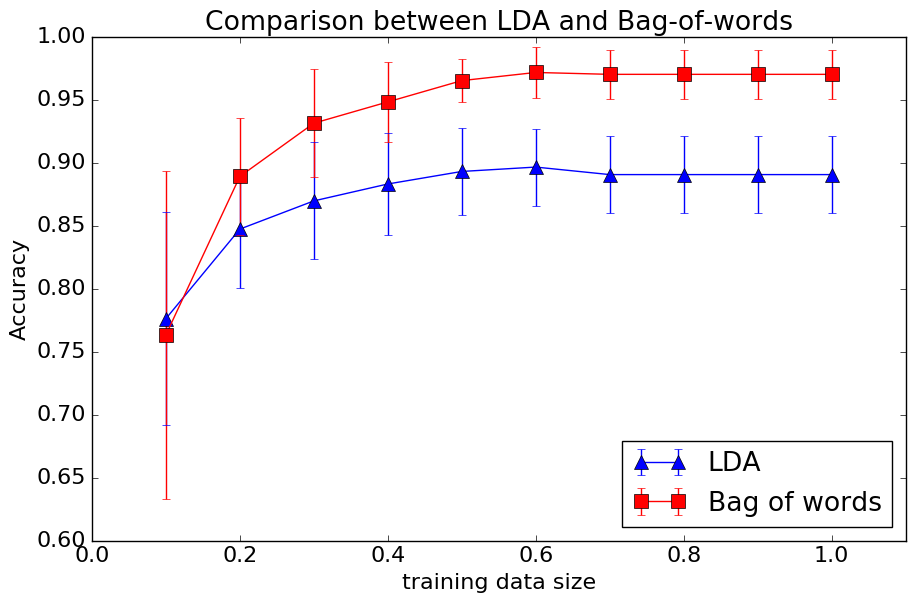

In [14]:
fig = plt.gcf()
fig.set_size_inches(10.5, 6.5)
matplotlib.rcParams.update({'font.size': 16})
plt.errorbar(size_vec, acc_topic_mean, yerr = acc_topic_std, fmt = 'b-^', markersize = 10)
plt.errorbar(size_vec, acc_bow_mean, yerr = acc_bow_std, fmt = 'r-s', markersize = 10)
plt.xlabel('training data size')
plt.ylabel('Accuracy')
plt.title('Comparison between LDA and Bag-of-words')
plt.legend(['LDA','Bag of words'], loc = 4)
plt.xlim(0,1.1)

## Discussion:

We can see that the Bag-of-words representation works better than the LDA representation when training dataset size is large. The LDA works only slightly better when training dataset size is small.